# Ostensibly examining VCF files with pyvcf
### But really, accessing remote files and some bioinformatic dictionary usage

Objectives:

* access remote files with streams or by downloading
* practise scanning through a file, in this case record by record of VCF files
* use dictionaries both to access INFO fields and to generate summary data
* Compare across dictionaries

In [118]:
import vcf
import urllib.request
import matplotlib.pylab as plt
%matplotlib inline

The version of pyvcf we're using here doesn't handle opening remote URLs as nicely as pandas does.  However,
it can take two types of input arguments; either something that looks like an open file, or a local filename.

`urllib` lets us deal with remote files with URLs very nicely in a couple of ways we'll look at:
scanning through the file, or just downloading it:

In [129]:
remote_readme="ftp://ftp-trace.ncbi.nih.gov/giab/ftp/release/NA12878_HG001/latest/README.NIST.v2.19.txt"
with urllib.request.urlopen(remote_readme) as remote_stream:
    linecount = 0
    for line in remote_stream:
        #print(line)
        print(line.decode('ascii'))
        linecount = linecount + 1
        if linecount > 3:
            break

NIST Genome in a Bottle NA12878 vcf/bed file repository (www.genomeinabottle.org)



This is a repository of integrated snp and indel calls for NA12878, along with bed file that includes regions in which we believe our genotype calls are highly accurate (including homozygous reference calls if no snp or indel is called).  This is an updated version of our calls from Zook et al, Nat Biotech, 2014 (http://www.nature.com/nbt/journal/v32/n3/full/nbt.2835.html), which fixes a bug that caused more indels to be uncertain than necessary, so that these calls contain significantly more indels.  Otherwise, methods are similar to those described in the manuscript.





We can open such a stream with a vcf reader and get the header information:

In [130]:
remote_file = "ftp://ftp-trace.ncbi.nih.gov/giab/ftp/release/NA12878_HG001/latest/NISTIntegratedCalls_14datasets_131103_allcall_UGHapMerge_HetHomVarPASS_VQSRv2.19_2mindatasets_5minYesNoRatio_all_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs.vcf.gz"
with urllib.request.urlopen(remote_file) as remote_stream:
    v = vcf.Reader(remote_stream, compressed=True)

    print('Variant Level information')
    infos = v.infos
    for info in infos:
        print(info)

    print('Sample Level information')
    fmts = v.formats
    for fmt in fmts:
        print(fmt)

Variant Level information
AC
AF
AN
DP
DPSum
Entropy
HRun
HapNoVar
LEN
NoCG
NoPLTot
PL454WG
PLCG
PLHSWEx
PLHSWG
PLILL250
PLILLCLIA
PLILLWEx
PLILLWG
PLIllPCRFree
PLIonEx
PLPlatGen
PLXIll
PLXPSolWGLS
PLminsum
PLminsumOverDP
RPA
RU
TYPE
TrancheABQDmin2
TrancheAlignmin2
TrancheMapmin2
TrancheSSEmin2
YesPLtot
allalts
datasetcalls
filter
geno
genoMapGood
platformbias
platformnames
platforms
varType
Sample Level information
DP
GQ
GT
PL


But because we'll be scanning over this file repeatedly, let's get a subset of it locally:

In [104]:
chr20_filename="https://github.com/ljdursi/mon_py_wrkshp/blob/master/NISTIntegratedCalls_chr20.vcf.gz?raw=true"
localfilename="NIST_chr20.vcf.gz"
urllib.request.urlretrieve(chr20_filename, localfilename)

('NIST_chr20.vcf.gz', <http.client.HTTPMessage at 0x109891780>)

Let's see what we can do with one of these files.  When we open a vcf file, we have to call a function `next` to get a record:

In [146]:
reader = vcf.Reader(filename=localfilename)
record = next(reader)
print(record)
print(record.INFO)
print(record.INFO['platformnames'])
print(record.samples)
print(record.samples[0]['GT'])

Record(CHROM=20, POS=61138, REF=C, ALT=[CT])
{'RPA': [12, 13], 'platforms': 1, 'PLminsum': 4173, 'HapNoVar': 0, 'PLILLWG': ['133', '0', '108', '133', '133', '133'], 'PLNCIIonWG': ['0', '127', '127', '18', '127', '127'], 'PLILLCLIA': ['512', '0', '657', '657', '657', '657'], 'TrancheSSEmin2': 90.0, 'platformbias': ['none'], 'TrancheABQDmin2': 90.0, 'datasetcalls': 10, 'PLPlatGen': ['1922', '0', '2315', '2315', '2315', '2315'], 'PLIonEx': ['filteredSSE99.9Align99.9', '0', '46', '46', '6', '46', '46'], 'TrancheAlignmin2': 0.0, 'platformnames': ['ill'], 'varType': 'INDEL', 'PLHSWG': ['684', '0', '649', '684', '684', '684'], 'PLIllPCRFree': ['466', '0', '430', '466', '466', '466'], 'HRun': 0, 'YesPLtot': 7, 'geno': 2, 'RU': 'T', 'PLminsumOverDP': 7.31, 'PLXIll': ['281', '0', '284', '284', '284', '284'], 'genoMapGood': 7, 'allalts': ['CT', 'T'], 'DPSum': 571, 'NoPLTot': 1, 'PLCG': ['6', '0', '100', '100', '100', '100'], 'TrancheMapmin2': 0.0, 'PLILL250': ['296', '0', '430', '430', '430', '43

The usual way to process a file, VCF or otherwise, is to loop over lines in the file and process them as you like:

In [147]:
reader = vcf.Reader(filename=localfilename)
recordnum = 0
for record in reader:
    print(record, record.samples[0]['GT'])
    recordnum += 1
    if recordnum == 5:
        break

Record(CHROM=20, POS=61138, REF=C, ALT=[CT]) 0/1
Record(CHROM=20, POS=67500, REF=T, ALT=[TTGGTATCTAG]) 0/1
Record(CHROM=20, POS=68749, REF=T, ALT=[C]) 1/1
Record(CHROM=20, POS=70484, REF=CTCTT, ALT=[C]) 0/1
Record(CHROM=20, POS=70980, REF=G, ALT=[A]) 0/1


Hands-on: write a function, `get_depths`, which is given a filename and generates a list of all `DPSum` info fields - this is the total depth across all platforms at which this base was seen.

In [120]:
def get_depths(input_file):
    depth_counts = []
    depth_item = 'DPSum'
    reader = vcf.Reader(filename=input_file)
    for record in reader:
        if depth_item in record.INFO:
            depth = int(record.INFO[depth_item])
            depth_counts.append(depth)
    return depth_counts

In [122]:
depths = get_depths(localfilename)

(array([  5.00000000e+00,   7.00000000e+00,   1.30000000e+01,
          1.70000000e+01,   2.90000000e+01,   3.30000000e+01,
          6.00000000e+01,   9.60000000e+01,   1.05000000e+02,
          1.76000000e+02,   2.13000000e+02,   3.31000000e+02,
          4.50000000e+02,   5.55000000e+02,   8.07000000e+02,
          1.07400000e+03,   1.47600000e+03,   2.01000000e+03,
          2.66600000e+03,   3.63600000e+03,   5.19100000e+03,
          6.66000000e+03,   9.00000000e+03,   9.50300000e+03,
          9.59300000e+03,   7.85300000e+03,   5.22900000e+03,
          3.10800000e+03,   1.52900000e+03,   7.44000000e+02,
          3.66000000e+02,   1.54000000e+02,   1.08000000e+02,
          9.00000000e+01,   6.50000000e+01,   6.00000000e+01,
          5.20000000e+01,   4.60000000e+01,   3.20000000e+01,
          1.80000000e+01,   1.70000000e+01,   1.50000000e+01,
          3.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   2.00000000e+00,
        

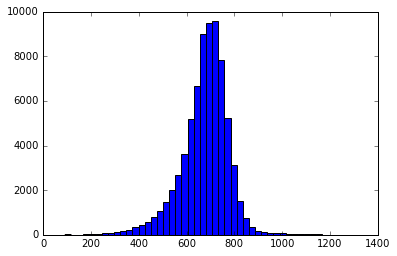

In [124]:
plt.hist(depths, bins=50)

TODO:

* Demonstrate: get counts as dictionary
    * defaultdict
* Hands on: generate defaultdict of counts by varianttype, genotype
* Generate list of dictionaries of calls by platform type; using those, investigate overlap and no-overlap of calls by platform.  Eg, how many calls were made by illumina that weren't made by 10x?